In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import arviz as az
import stan

from sklearn.linear_model import BayesianRidge
from sklearn.utils import shuffle

import nest_asyncio
nest_asyncio.apply()

# Bayesian Multiple Regression: an Insurance Model

> Please note: this notebook combines Problem 05 and 06 for this assignment. We try to partition this notebook so that it is easy to grade. When grading, please consider the grading of these problems separately. 

In this notebook, we implement a multiple Bayesian Linear Regression model. This model is used to fit the [Insurance Cost dataset](https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv), where we predict the insurance charges based upon a patient's BMI, age, and children count.

This model is implemented in two ways: both in `Stan` and with `scikit-learn`'s Bayesian Ridge regression implementation.

## Part 0: Data Preprocessing

In [4]:
# Reading in the data
all_data = pd.read_csv('./data/insurance.csv', delimiter=";")

In [5]:
# Inspecting the content of the data
all_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
# Inspecting how much data there is
all_data.shape

(1338, 7)

In [7]:
data = all_data[['age','bmi', 'children', 'charges']]
data.shape

(1338, 4)

In [8]:
charges_std = data['charges'].std()
std = np.std(data, axis=0)
std

age            14.044709
bmi             6.095908
children        1.205042
charges     12105.484976
dtype: float64

In [9]:
def z_standardize(input_data):
    """ 
    Helper function to standardize data.

    Parameters
    ----------
    Input_data      : np.array
        Input data to be standardized
    
    Returns
    -------
    output_data     : np.array
        Standardized data
    """

    output_data = (input_data - np.mean(input_data, axis=0)) / np.std(input_data, axis=0)

    return output_data

def destandardize(data_z, input_mean, input_std):
    """ 
    Helper function to destandardize data.
    """

    return data_z * input_std + input_mean 

In [10]:
# Perform z_standardization for all data
data_z = z_standardize(data)
data_z

,age,bmi,children,charges
0,-1.438764,-0.453320,-0.908614,0.298584
1,-1.509965,0.509621,-0.078767,-0.953689
2,-0.797954,0.383307,1.580926,-0.728675
3,-0.441948,-1.305531,-0.908614,0.719843
4,-0.513149,-0.292556,-0.908614,-0.776802
...,...,...,...,...
1333,0.768473,0.050297,1.580926,-0.220551
1334,-1.509965,0.206139,-0.908614,-0.914002
1335,-1.509965,1.014878,-0.908614,-0.961596
1336,-1.296362,-0.797813,-0.908614,-0.930362


Here, we perform a train-test split by reshuffling the data and roughly split them so that 70% of the dataset is used for training.

In [11]:
# Perform a train-test split with a simple cutoff index 1000.

# First, shuffle the dataset to ensure consistency between training and testing set
data_z = shuffle(data_z)

In [21]:
# Then do the split.
train_data = data_z[0:1000].to_numpy()
test_data  = data_z[1000:].to_numpy()

## Part 1: Generative Model

Next, we will build a simple Bayesian regression model of the form:
$$
\begin{align}
    \nonumber \sigma &\sim \text{Inv-Gamma}(\tau_0, \tau_1)\\
    \nonumber \alpha &\sim \text{Normal}(0, \sigma_\alpha)\\
    \nonumber \beta &\sim \text{Multivariate-Normal}(0, \sigma_\beta \mathbb{I})\\
\nonumber y_n &\sim \mathrm{Normal}(\alpha + \beta\,x_n^T, \sigma) \quad \text{for} \,\, n = 1,\dots,N
\end{align}
$$

For the model, we set the hyperparameters $\tau_0 = \tau_1 = 1, \sigma_\alpha = 10, \sigma_\beta = (1, 1, 1)$.

In [35]:
insurance_code = """ 
data {
    int<lower=1> N; // Observation count
    int<lower=1> K; // Predictor count
    matrix[N, K] x; // Predictor matrix
    vector[N] y;
}

parameters {
    real alpha;
    vector[K] beta;
    real<lower=0> sigma;
}

model {
    // Priors
    alpha ~ normal(0, 10);
    beta ~ multi_normal(rep_vector(0, K), identity_matrix(K));
    sigma ~ inv_gamma(1, 1);

    // Likelihood
    y ~ normal(alpha + x * beta, sigma);
}
"""

In [42]:
predictors = train_data[:,0:3]

insurance_data = {
    "N": train_data.shape[0],
    "K": predictors.shape[1],
    "x": predictors,
    "y": train_data[:,-1]
}

predictors.shape

(1000, 3)

In [43]:
insurance_posterior = stan.build(program_code=insurance_code, data=insurance_data, random_seed=1069)

Building...



Building: found in cache, done.

In [45]:
fit = insurance_posterior.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Sampling:   0%


Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 0.00017 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.7 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000129 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.29 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000165 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.65 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000128 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.28 seconds.
  Adjust your expectations accordingly!


In [46]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.011,0.029,-0.065,0.044,0.0,0.0,11726.0,7881.0,1.0
beta[0],0.293,0.029,0.237,0.345,0.0,0.0,12458.0,8227.0,1.0
beta[1],0.162,0.029,0.109,0.219,0.0,0.0,11467.0,8032.0,1.0
beta[2],0.055,0.029,0.001,0.109,0.0,0.0,11859.0,8134.0,1.0
sigma,0.929,0.021,0.892,0.969,0.0,0.0,12132.0,7289.0,1.0


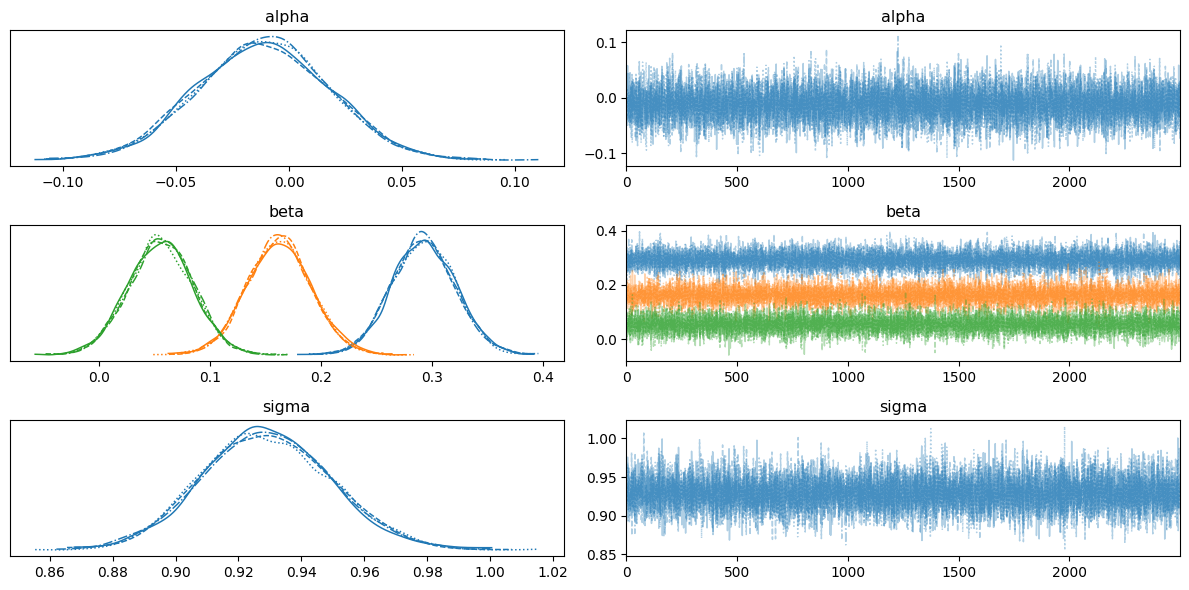

In [48]:
ax = az.plot_trace(fit)
plt.tight_layout()